<a href="https://colab.research.google.com/github/paulomarc49/ETo_climate/blob/main/ETo_weather_training_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data Loading

### 1.1. The data of year 2021 and 2022 was previus treated, joined and saved as a numpy file in a Linux system.
### 1.2. The data rest in the google drive repository:

 * **2021 2022:** https://drive.google.com/file/d/1-SLYUEciTHd4OCSbqXoJ6fdOaYIGl_ao/view?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import joblib
import os
from tqdm import tqdm

# Load preprocessed data for the years 2021 and 2022 as a NumPy array.
# If Drive access is unavailable, download the data from the provided links and edit your directory.
numpy_data_2021_2022 = np.load('/content/drive/MyDrive/ETo/2021_2022_numpy.npy')
print("Shape of the original data:  ",numpy_data_2021_2022.shape)

# Reduce the size in memory of the files
numpy_data_2021_2022 = numpy_data_2021_2022.astype(np.float16)

# Save the data in new format
folder_path = '/content/ETo_weather_training'
os.mkdir(folder_path)
outpath = '/content/ETo_weather_training/2021_2022_numpy_float16.npy'
np.save( outpath, numpy_data_2021_2022, allow_pickle=False )
print("Shape of the formatted data: ",numpy_data_2021_2022.shape)

# Data flattening
# Input data is an array of three dimentions with the shape: ( d * y, x, 8 variables * 24 hours ), where:
# d: number of days,
# y: Pixel "Y",
# x: Pixel "X",
# 8 variables * 24 per 24 hours
numpy_data_2021_2022 = numpy_data_2021_2022.reshape(-1, 192)
print("Shape of the flattened data: ",numpy_data_2021_2022.shape)

Shape of the original data:   (124830, 171, 192)
Shape of the formatted data:  (124830, 171, 192)
Shape of the flattened data:  (21345930, 192)


## 2. SOM

* The project is based in a custom sci-kit learn SOM

In [2]:
# Installing scikit-learn SOM package
!pip install sklearn-som
!pip install joblib

# Making Custom scikit-learn SOM package
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn_som.som import SOM as SklearnSOM

class CustomSOM(BaseEstimator, ClusterMixin):
    def __init__(self, m=1, n=1, dim=1, sigma=1, lr=1, max_iter=1, random_state=None):
        self.m = m
        self.n = n
        self.dim = dim
        self.sigma = sigma
        self.lr = lr
        self.max_iter = max_iter
        self.random_state = random_state
        self.model_ = None

    def fit(self, X, y=None):
        self.model_ = SklearnSOM(m=self.m, n=self.n, dim=self.dim, lr=self.lr, max_iter=self.max_iter, random_state=self.random_state)
        self.model_.fit(X)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def transform(self, X):
        return self.model_.transform(X)

    def score(self, X, y=None):
        distancias_punto_centroide = self.transform(X)
        distorsion_total = 0
        for i in range(len(distancias_punto_centroide)):
            distancias_minimas_cuadradas = (np.min(distancias_punto_centroide[i]))**2
            distorsion_total += distancias_minimas_cuadradas
        return distorsion_total

## 3. Training the model


### 3.1. Training one day data for model review using scikit-learn pipelines

In [3]:
from sklearn.preprocessing     import StandardScaler
from sklearn.pipeline          import Pipeline

# Function for plotting one day SOM clusters:
def plot_one_day(numpy_data, classes):
    x, y, n_variables = 171, 171, 192
    # Flattering original array
    variables_flat = numpy_data
    variables_flat = variables_flat[0:29241]
    print(f"The one day input data has a shape of:             {variables_flat.shape}")
    # Reshape labels array
    classes = classes.reshape(-1, 1)
    classes = classes[0:29241]
    print(f"The one day output labels has a shape of:          {classes.shape}")
    # Join of flattered original array and labels array
    array_con_etiquetas = np.concatenate((variables_flat, classes), axis=-1)
    print(f"The one day joined array has a shape of:           {array_con_etiquetas.shape}")
    # Reshape of joined array
    array_con_etiquetas = array_con_etiquetas.reshape(1, y, x, 193)
    array_con_etiquetas = array_con_etiquetas.reshape(1 * y , x, 193)
    print(f"The one day reshaped joined array has a shape of:  {array_con_etiquetas.shape}")
    # Plot code
    import matplotlib.pyplot as plt
    data = array_con_etiquetas[:,:,192] # Plot at noon
    plt.figure(figsize=(5, 4))
    plt.imshow(data, cmap='gnuplot2', interpolation='bilinear')
    plt.colorbar(label='ETo clusters')
    plt.title(f'ETo wheather heatmap with distortion:\n{distortion}')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.show()

The one day input data has a shape of:             (29241, 192)
The one day output labels has a shape of:          (29241, 1)
The one day joined array has a shape of:           (29241, 193)
The one day reshaped joined array has a shape of:  (171, 171, 193)


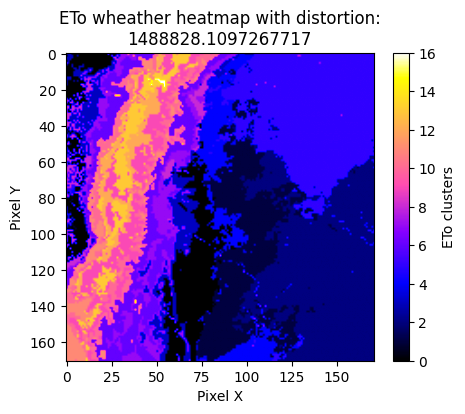

In [4]:
# Filtering original 2 years data to one day data:
numpy_data_one_day  = numpy_data_2021_2022[0:29241]

# Train the one day data model with pipeline:
from tqdm import tqdm
model_SOM_2 = Pipeline([('scal', StandardScaler()),
                        ('som', CustomSOM(m=8,
                                          n=3,
                                          dim=192,
                                          lr=1.5,
                                          max_iter=90,
                                          random_state=42))
                       ])

SOM_train_inicial = model_SOM_2[:-1].fit_transform(numpy_data_one_day)
SOM_train         = model_SOM_2[-1].fit(SOM_train_inicial)
labels_SOM_train  = model_SOM_2.named_steps['som'].predict(SOM_train_inicial)
distortion        = model_SOM_2.named_steps['som'].score(SOM_train_inicial)

plot_one_day(numpy_data_2021_2022, labels_SOM_train)

### 3.2. Training two years data

In [5]:
# Normalization of the data:
scaler = StandardScaler()
numpy_data_2021_2022_normalized = scaler.fit_transform(numpy_data_2021_2022)
print('The two years normalized data has a shape of: ', numpy_data_2021_2022_normalized.shape)

# Save normalized data:
outpath = '/content/ETo_weather_training/2021_2022_numpy_normalized.npy'
np.save( outpath, numpy_data_2021_2022_normalized, allow_pickle=False )

The two years normalized data has a shape of:  (21345930, 192)


In [6]:
# Uncomment to load the normalized data:
#numpy_data_2021_2022_normalized = np.load('/content/ETo_weather_training/2021_2022_numpy_normalized.npy')
#print('The two years normalized data loaded has a shape of: ', numpy_data_2021_2022_normalized.shape)

The two years normalized data loaded has a shape of:  (21345930, 192)


In [7]:
# Training the custom scikit-learn SOM model:
som_model = CustomSOM(m=8, n=3, dim=192, lr=1.5, max_iter=90, random_state=42)
som_model.fit(numpy_data_2021_2022_normalized)

# Save the trained custom scikit-learn SOM model:
joblib.dump(som_model, '/content/drive/MyDrive/ETo_weather/ETo_weather_som_model.pkl')

['/content/drive/MyDrive/ETo_weather/ETo_weather_som_model.pkl']

In [8]:
# Prediction of the labels for the ETo weather clusters:
from joblib import Parallel, delayed

# Function to predict SOM labels for a chunk of data
def predict_chunk(som_model, data_chunk):
    return som_model.predict(data_chunk)

# Function to divide the data into chunks and process them in parallel
def process_data_in_parallel(som_model, data, n_jobs=-1, chunk_size=None):
    n_samples = data.shape[0]
    if chunk_size is None:
        chunk_size = n_samples // 90  # Default to dividing data into 10 chunks if not provided
    data_chunks = [data[i:i + chunk_size] for i in range(0, n_samples, chunk_size)]

    # Parallel processing of each chunk
    results = Parallel(n_jobs=n_jobs)(delayed(predict_chunk)(som_model, chunk) for chunk in data_chunks)

    # Join the predicted labels
    return np.concatenate(results)

# Predictions and labels generation
outpath_ETo_weather_labels = '/content/ETo_weather_training/2021_2022_numpy_labels.npy'

# Check if the labels file already exists
if not os.path.exists(outpath_ETo_weather_labels):
    # Process data in parallel and predict labels
    som_model = joblib.load('/content/drive/MyDrive/ETo_weather/ETo_weather_som_model.pkl') #If do not want to train new model can download the trained one from: https://drive.google.com/file/d/1E771bVe5fM3JDX-otPUqUdcIXk0l-lJ-/view?usp=drive_link
    labels_SOM_train = process_data_in_parallel(som_model, numpy_data_2021_2022_normalized)
    # Save the labels array
    np.save(outpath_ETo_weather_labels, labels_SOM_train.astype(np.int16), allow_pickle=False)
    print(f'Labels array saved to: {outpath_ETo_weather_labels}\n')
    print('The two years ETo weather labels vector has a shape of: ', labels_SOM_train.shape)
else:
    print(f'File already exists at {outpath_ETo_weather_labels}')

Labels array saved to: /content/ETo_weather_training/2021_2022_numpy_labels.npy
The two years ETo weather labels vector has a shape of:  (21345930,)


In [9]:
# Join of labels and original dataset
outpath_ETo_weather = '/content/ETo_weather_training/ETo_weather_2021_2022.npy'

if not os.path.exists(outpath_ETo_weather):
    labels_SOM_train = np.load('/content/ETo_weather_training/2021_2022_numpy_labels.npy')
    labels_SOM_train = labels_SOM_train.astype(np.int16)
    ETo_weather = np.concatenate((numpy_data_2021_2022, labels_SOM_train.reshape(-1,1)), axis=1)
    np.save(outpath_ETo_weather, ETo_weather, allow_pickle=False)
    print(f'Labels array saved to: {outpath_ETo_weather}\n')
    print('The two years ETo weather data joined with the labels vector has a shape of: ', ETo_weather.shape)
else:
    print(f'File already exists at {outpath_ETo_weather}, ')

Labels array saved to: /content/ETo_weather_training/ETo_weather_2021_2022.npy

The two years ETo weather data joined with the labels vector has a shape of:  (21345930, 193)


## 4. Visualization and simulation

In [10]:
# Unflattening operations for plotting tasks:
d, y, x, n_variables = 730, 171, 171, 192
outpath_ETo_weather_unflattened = '/content/ETo_weather_training/ETo_weather_reshaped_2021_2022.npy'

if not os.path.exists(outpath_ETo_weather_unflattened):
    ETo_weather = np.load('/content/ETo_weather_training/ETo_weather_2021_2022.npy')
    print(f"The two years ETo weather data joined with the labels vector has a shape of: {ETo_weather.shape}")
    #ETo_weather_reshaped = ETo_weather.reshape(d, y, x, 193)
    #print(f"First reshape of the original array with labels: {ETo_weather_reshaped.shape}")
    ETo_weather_unflattened = ETo_weather.reshape(d * y, x, 193)
    np.save(outpath_ETo_weather_unflattened, ETo_weather_unflattened, allow_pickle=False)
    print(f'Labels array saved to: {outpath_ETo_weather_unflattened}\n')
    print(f"The two years ETo weather unflattened and joined data has a shape of: {ETo_weather_unflattened.shape}")
else:
    print(f'File already exists at {outpath_ETo_weather_unflattened}')

The two years ETo weather data joined with the labels vector has a shape of: (21345930, 193)
Labels array saved to: /content/ETo_weather_training/ETo_weather_reshaped_2021_2022.npy

The two years ETo weather unflattened and joined data has a shape of: (124830, 171, 193)


In [16]:
# Uncomment to load the normalized data:
#ETo_weather_unflattened = np.load('/content/ETo_weather_training/ETo_weather_reshaped_2021_2022.npy')
#print('The two years ETo weather unflattened and joined data has a shape of: ', ETo_weather_unflattened.shape)

The two years ETo weather unflattened and joined data has a shape of:  (124830, 171, 193)


In [12]:
%matplotlib inline

!pip install ipywidgets>=7,<8

import ipywidgets         as widgets
import matplotlib.pyplot  as plt
from IPython.display      import display
from PIL                  import Image
from matplotlib.widgets   import Cursor
from google.colab         import output

/bin/bash: line 1: 8: No such file or directory


In [17]:
output.enable_custom_widget_manager()
dropdown = widgets.Dropdown(
    options=[('Net radiation', 0),
             ('Ground Flux', 1),
             ('Air temperature at 2 m', 2),
             ('Slope vapour pressure curve', 3),
             ('Psychrometric const', 4),
             ('Saturation vapour pressure', 5),
             ('Actual vapour pressure', 6),
             ('Wind speed magnitude at 2m', 7),
             ('Evapotranspiration Penman-Monteith', 8)],
    value=0,
    description='VARIABLES:',
)

dropdown1 = widgets.IntSlider(min=0, max=23,  step=1, description='HOUR:')
dropdown2 = widgets.IntSlider(min=0, max=729, step=1, description='DAY:' )

# Animation
play = widgets.Play(
    value=0,
    min=0,
    max=729,
    step=1,
    interval=2500,
    description="Press play",
    disabled=False
)

def Dropdown_Menu(value=1, hora=1, dia=1):
    fig, (ax) = plt.subplots(1, 1, figsize=(9, 3))
    fig.dpi = 140

    x = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    z = list(range(0, 730))

    pos   = x.index(value)
    horas = y.index(round(hora))
    dias  = z.index(round(dia))

    # (124830, 171, 193)
    dia1 = ETo_weather_unflattened[0 + (171*(dias)) : 171 + (171*(dias))]

    var_name = ['Net radiation MJ/(m2*hr)', 'Ground Flux MJ/(m2*hr)', 'Air temperature at 2 m °C',
                'Slope vapour pressure curve kPa °C-1', 'Psychrometric const kPa °C-1',
                'Saturation vapour pressure kPa', 'Actual vapour pressure kPa',
                'Wind speed magnitude at 2m m/s', 'Evapotranspiration mm/day'][pos]

    label_name = ['MJ/(m2*hr)', 'MJ/(m2*hr)', '°C',
                'kPa °C-1', 'kPa °C-1',
                'kPa', 'kPa',
                'm/s', 'mm/day'][pos]


    data         = dia1[:,:,round(pos+(horas*8))]
    rad          = dia1[:,:,round(0 + (horas*8))]
    flux         = dia1[:,:,round(1 + (horas*8))]
    temp         = dia1[:,:,round(2 + (horas*8))]
    slope_vapour = dia1[:,:,round(3 + (horas*8))]
    g            = dia1[:,:,round(4 + (horas*8))]
    saturation_p = dia1[:,:,round(5 + (horas*8))]
    actual_p     = dia1[:,:,round(6 + (horas*8))]
    speed        = dia1[:,:,round(7 + (horas*8))]
    ETo = ( (0.408 * slope_vapour * (rad - flux)) + g * ( (37)/(temp + 273) ) * (speed)*(saturation_p - actual_p) ) / (slope_vapour + g * (1 + 0.34 * speed))
    # Clear the axes to update the plots
    ax.clear()
    plt.subplots_adjust(left   = 0.1,
                        bottom = 0.1,
                        right  = 0.9,
                        top    = 0.9,
                        wspace = 0.4,
                        hspace = 0.1)

    scala_inf = [-1.0, -0.05,  5.00, 0.00, 0.03, 0, 0, 0, -0.21]
    scala_sup = [ 0.9,  0.20, 31.00, 0.25, 0.08, 4, 3, 5, 0.72]

    titulo_dinamico =  f'\n"{var_name}"'
    if pos == 8:
        im = ax.imshow(ETo, cmap='gnuplot2', vmin=scala_inf[pos], vmax=scala_sup[pos], alpha=1, interpolation='bilinear')
    else:
        im = ax.imshow(data, cmap='gnuplot2', vmin=scala_inf[pos], vmax=scala_sup[pos], alpha=1, interpolation='bilinear')
    ax.set_title(titulo_dinamico, color="steelblue")
    ax.set_xlabel('Geographic pixel in X axis')
    ax.set_ylabel('Geographic pixel in Y axis')

    plt.colorbar(im, ax=ax, label= label_name)
    plt.show()

widgets.jslink((play, 'value'), (dropdown2, 'value'))
widgets.interact(Dropdown_Menu, value=dropdown, hora=dropdown1, dia=dropdown2)
widgets.HBox([play])

interactive(children=(Dropdown(description='VARIABLES:', options=(('Net radiation', 0), ('Ground Flux', 1), ('…

In [23]:
output.enable_custom_widget_manager()
dropdown2 = widgets.IntSlider(min=0, max=729, step=1, description='DAY:')

play = widgets.Play(
    value=0,
    min=0,
    max=729,
    step=1,
    interval=1000,
    description="Press play",
    disabled=False
)

def Dropdown_Menu(dia=1):
    fig, (ax) = plt.subplots(1, 1, figsize=(9, 3))
    fig.dpi = 100

    y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    z = lista = list(range(0, 730))

    dias = z.index(round(dia))

    dia1 = ETo_weather_unflattened[0 + (171*(dias)) : 171 + (171*(dias))]

    data = dia1[:,:,round((192))]
    ETo_cluster = dia1[:,:,round((192))]
    ax.clear()
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.1)

    titulo_dinamico =  "ETo Weather Clusters for 2021 and 2022"
    im = ax.imshow(data, cmap='gnuplot2', vmin=0, vmax=24, alpha=1, interpolation='bilinear')
    ax.set_title(titulo_dinamico, color="steelblue")
    ax.set_xlabel('Geographic pixel in X axis')
    ax.set_ylabel('Geographic pixel in Y axis')
    plt.colorbar(im, ax=ax, label="Clusters")
    plt.show()

widgets.jslink((play, 'value'), (dropdown2, 'value'))

widgets.interact(Dropdown_Menu, dia=dropdown2)
widgets.HBox([play])


interactive(children=(IntSlider(value=0, description='DAY:', max=729), Output()), _dom_classes=('widget-intera…